In [1]:
import cv2 as cv
import cv2
from os import listdir
import math
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import pandas as pd
from scipy import optimize
from tqdm import tqdm

In [2]:
cv2.__version__

'3.4.2'

In [3]:
np.__version__

'1.18.1'

In [4]:
# def show_two_eyes(eye1, eye2):
#     max_shape_0 = max([eye1.shape[0], eye2.shape[0]])
#     max_shape_1 = max([eye1.shape[1], eye2.shape[1]])
#     eye1_reshaped = np.pad(eye1, ((0, max_shape_0 - eye1.shape[0]), (0, max_shape_1 - eye1.shape[1])), \
#        'constant', constant_values=(255))
#     eye2_reshaped = np.pad(eye2, ((0, max_shape_0 - eye2.shape[0]), (0, max_shape_1 - eye2.shape[1])), \
#        'constant', constant_values=(255))
#     plt.imshow(np.hstack((eye1_reshaped, eye2_reshaped)), cmap='gray')
#     plt.show()

In [5]:
# def show_single_eye(eye):
#     plt.imshow(eye)
#     plt.show()

# Setup
## Define the paths

In [4]:
haarcascade_path = '../outside_sources/haarcascade/'
sripts_path = '../sripts/facial_landmark/'
raw_data_path = '../data/raw/full/'
original_raw_data_path = '../data/raw/full_orig/'
labels_path = '../data/labels/'
output_img_path = '../data/final_outcome/'
model_path = '../models/'

## Parse the labeled data from Dr. Liu and prepare testing & validation set

In [15]:
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')
df_img_info.head()

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0
2,2MR10489169120318-374.87.JPG,3.jpg,1,1,1,0,0,0,0
3,2DM15140817020618-374.33.JPG,4.jpg,1,0,0,0,0,0,1
4,2FM16841546011618-374.33.JPG,5.jpg,0,0,0,0,0,1,1


In [17]:
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')

labeled_data_dir = '../data/processed/left_akg_all/'
lebel_file_dir = '../data/labels/cl/'
all_testing_img = []
for label in listdir(lebel_file_dir):
    tmp_name = label.replace('_left.txt', '.JPG')
    tmp_df = df_img_info.query('original_name == "' + tmp_name + '"')
    if tmp_df.shape[0] == 0:
        print('Something wrong with:', label)
        continue
    orderred_img_idx = int(tmp_df.orderred_name.iloc[0].replace('.jpg', ''))
    all_testing_img.append(orderred_img_idx)
print(len(all_testing_img))

100


## Preprocessing the images

### Convert the file names, uncommon if files are not numberred

In [5]:
# curr_file_count = 0
# for filename in listdir(raw_data_path):
#     try:
#         cv2.imread(original_raw_data_path + filename)
#         curr_file_count += 1
#     except:
#         continue
# print('Currently have:', curr_file_count, 'file(s) as raw data.')
# # count = curr_file_count + 1
# count = 1

# mapping_from_old = []
# for filename in listdir(original_raw_data_path):
#     try:
#         img = cv2.imread(original_raw_data_path + filename)
#     except:
#         print('[ERROR] Cannot read file:', filename)
#         continue
#     cv2.imwrite(raw_data_path + str(count) + '.jpg', img) 
#     mapping_from_old.append({
#         'original_name': filename,
#         'orderred_name': str(count) + '.jpg'
#     })
#     count += 1

In [5]:
list_of_files = listdir(raw_data_path)
print('Count of images:', len(list_of_files))

Count of images: 269


In [6]:
# df_img_info = pd.DataFrame(mapping_from_old)
# df_img_info.to_csv('../data/labels/df_img_info.csv', index = False)
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')
df_img_info.head()

,original_name,orderred_name,left_found,right_found,both_found,left_hard,right_hard,left_failed,right_failed
0,2MM23355506081418-375.22.JPG,1.jpg,1,1,1,0,0,0,0
1,2ES30404089011618-374.87.JPG,2.jpg,1,1,1,0,0,0,0
2,2MR10489169120318-374.87.JPG,3.jpg,1,1,1,0,0,0,0
3,2DM15140817020618-374.33.JPG,4.jpg,1,0,0,0,0,0,1
4,2FM16841546011618-374.33.JPG,5.jpg,0,0,0,0,0,1,1


In [7]:
df_img_info.shape

(269, 9)

## Check if the raw data is ready

In [8]:
ready = False
for file in listdir(raw_data_path):
    if 'png' in file or 'jpg' in file or 'JPG' in file:
        ready = True
        break
if ready:
    print('[SETUP] Data is ready!')
else:
    print('[SETUP] Data is NOT ready!')

[SETUP] Data is ready!


# Detect Eyes
## Step1: Use OpenCV CascadeClassifier

In [12]:
import copy

In [13]:
def detect_eye(directory, filename):
    '''
    input:
        directory: directory to the input image (in RGB)
        filename: name of the file
    output:
        img1: image segmentation of one of an eye (type: np.ndarray)
        img2: image segmentation of another eye (type: np.ndarray)
        outpue: original image with the rectangle plotted on the segmented areas
    '''
    # 1. Readin the image and return if there is an error
    print('=================================')
    print('Now Processing:', filename + '...')
    try:
        gray = cv2.imread(directory + filename, 0)
        output = cv2.imread(directory + filename, 0)
    except:
        print(filename, 'is not an image!')
        return -1, -1, -1
    
    # 2. Processing image - detect eyes using CascadeClassifier
    gray = cv2.medianBlur(gray, 7)
#     gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    # [OLD WAY]
    eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(gray)
    if len(eyes) < 2:
        print('[Error!] Stupit classifier!!!')
        return -1, -1, -1
    # Pick the two "eyes" with largest sizes
    eyes = sorted(eyes, key = lambda x: x[2] + x[3], reverse = True)[:2]
    # Sort the "eyes" by their x position
    eyes = sorted(eyes, key = lambda x: x[0], reverse = False)  
    # 3. Crop the original image and return the two eye segments
    result = []
    for (ex,ey,ew,eh) in eyes:
        eye = output[ey-25:ey + eh + 25, ex - 25:ex + ew + 25]
        result.append(eye)
    
    print('Done processing:', filename + '!')
    return result[0], result[1], output

In [14]:
# def detect_eye(directory, filename):
#     '''
#     input:
#         directory: directory to the input image (in RGB)
#         filename: name of the file
#     output:
#         img1: image segmentation of one of an eye (type: np.ndarray)
#         img2: image segmentation of another eye (type: np.ndarray)
#         outpue: original image with the rectangle plotted on the segmented areas
#     '''
#     # 1. Readin the image and return if there is an error
#     print('=================================')
#     print('Now Processing:', filename + '...')
#     try:
#         gray = cv2.imread(directory + filename, 0)
#         output = cv2.imread(directory + filename)
#     except:
#         print(filename, 'is not an image!')
#         return -1, -1, -1
    
#     # 2. Processing image - detect eyes using CascadeClassifier
#     gray = cv2.medianBlur(gray, 5)
# #     gray = cv2.GaussianBlur(gray, (5,5), 0)
    
#     # [NEW WAY]    
#     left_eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_lefteye_2splits.xml')
#     left_eyes = left_eye_cascade.detectMultiScale(gray)
#     right_eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_righteye_2splits.xml')
#     right_eyes = right_eye_cascade.detectMultiScale(gray)
    
    
#     if len(left_eyes) < 1 or len(right_eyes) < 1:
#         eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_eye.xml')
#         eyes = eye_cascade.detectMultiScale(gray)
#         if len(eyes) < 2:
#             print('[Error!] Stupit classifier!!!')
#             return -1, -1, -1
#         if len(left_eyes) < 1:
#             print('[DEBUG] Left splider failed')
#             left_eyes = copy.deepcopy(eyes)
#         if len(right_eyes) < 1:
#             print('[DEBUG] Right splider failed')
#             right_eyes = copy.deepcopy(eyes)
    
#     def compare_eyes(e1, e2):
#         return (sum(np.square(e1 - e2))) ** (1/2)
#     all_result = []
#     for (lex,ley,lew,leh) in left_eyes:
#         for (rex,rey,rew,reh) in right_eyes:
#             if lex <= rex:
#                 continue
#             e1 = np.array([ley,lew,leh])
#             e2 = np.array([rey,rew,reh])
#             score = (-1) * (compare_eyes(e1, e2) - lew - rew - abs(lex - rex))
#             if abs(rex - lex) < min([lew, rew]):
#                 continue
#             all_result.append( (score, (rex,rey,rew,reh), (lex,ley,lew,leh)) )
#     result = []
    
#     if len(all_result) > 0:
#         all_result = sorted(all_result, key = lambda x: x[0], reverse = True)  
#         rex,rey,rew,reh = all_result[0][1]
#         lex,ley,lew,leh = all_result[0][2]
#         result.append(output[rey-25:rey + reh + 25, rex - 25:rex + rew + 25])
#         result.append(output[ley-25:ley + leh + 25, lex - 25:lex + lew + 25])
#     else:
#         print('[Error!] Stupit classifier!!!')
#         return -1, -1, -1
    
#     print('Done processing:', filename + '!')
#     return result[0], result[1], output

In [15]:
# eye1, eye2, out = detect_eye(raw_data_path, '8.jpg')
# face_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_frontalface_default.xml') 
# eye_cascade = cv2.CascadeClassifier(haarcascade_path + 'haarcascade_lefteye_2splits.xml')
# img = cv2.imread(raw_data_path + '54.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# faces = face_cascade.detectMultiScale(gray, 1.3, 5) 
# count = 0
# for (x,y,w,h) in faces: 
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
#     roi_gray = gray[y:y+h, x:x+w] 
#     roi_color = img[y:y+h, x:x+w] 
#     eyes = eye_cascade.detectMultiScale(roi_gray) 
#     print(eyes)
#     for (ex,ey,ew,eh) in eyes: 
#         cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,127,255),2) 
#     count +=1 
# plt.imshow(img)

In [16]:
len(list_of_files)

269

In [17]:
eyes = []
count = 0
start = 189
for i in range(start, len(list_of_files) + 1):
    filename = str(i) + '.jpg'
    eye1, eye2, out = detect_eye(raw_data_path, filename)
    count += 1
    if type(out) == int:
        print("[ERROR] Didn't find eye for img:", filename)
        continue
    eyes.append(np.array([eye1, eye2]))
    cv2.imwrite(processed_data_path_left + 'left_' + filename, cv2.GaussianBlur(eye2,(5,5),0)) 
    cv2.imwrite(processed_data_path_right + 'right_' + filename, cv2.GaussianBlur(eye1,(5,5),0)) 
#     cv2.imwrite(processed_data_path_left[:-1] + '_origin/' + 'left_' + filename, eye2) 
#     cv2.imwrite(processed_data_path_right[:-1] + '_origin/' + 'right_' + filename, eye1)

Now Processing: 189.jpg...
Done processing: 189.jpg!
Now Processing: 190.jpg...
Done processing: 190.jpg!
Now Processing: 191.jpg...
Done processing: 191.jpg!
Now Processing: 192.jpg...
Done processing: 192.jpg!
Now Processing: 193.jpg...
Done processing: 193.jpg!
Now Processing: 194.jpg...
Done processing: 194.jpg!
Now Processing: 195.jpg...
Done processing: 195.jpg!
Now Processing: 196.jpg...
Done processing: 196.jpg!
Now Processing: 197.jpg...
Done processing: 197.jpg!
Now Processing: 198.jpg...
Done processing: 198.jpg!
Now Processing: 199.jpg...
Done processing: 199.jpg!
Now Processing: 200.jpg...
Done processing: 200.jpg!
Now Processing: 201.jpg...
Done processing: 201.jpg!
Now Processing: 202.jpg...
Done processing: 202.jpg!
Now Processing: 203.jpg...
Done processing: 203.jpg!
Now Processing: 204.jpg...
Done processing: 204.jpg!
Now Processing: 205.jpg...
Done processing: 205.jpg!
Now Processing: 206.jpg...
Done processing: 206.jpg!
Now Processing: 207.jpg...
Done processing: 20

## Step2: Manually Select the Ones that Works Well

In [9]:
# df_img_info['left_found'] = 0
# df_img_info['right_found'] = 0
# df_img_info['both_found'] = 0
# df_img_info['left_hard'] = 0
# df_img_info['right_hard'] = 0
# df_img_info['left_failed'] = 0
# df_img_info['right_failed'] = 0

# def adding_manual_selection_info(s):
#     filename = s.orderred_name
#     if 'left_' + filename in listdir(processed_data_path_left):
#         s['left_found'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right):
#         s['right_found'] = 1
#     if s['right_found'] == 1 and s['left_found'] == 1:
#         s['both_found'] = 1
    
#     if 'left_' + filename in listdir(processed_data_path_left + 'hard_eyes/'):
#         s['left_hard'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right + 'hard_eyes/'):
#         s['right_hard'] = 1
        
#     if 'left_' + filename in listdir(processed_data_path_left + 'eye_detection_failed/'):
#         s['left_failed'] = 1
#     if 'right_' + filename in listdir(processed_data_path_right + 'eye_detection_failed/'):
#         s['right_failed'] = 1
#     return s
# df_img_info = df_img_info.apply(adding_manual_selection_info, axis = 1)
# df_img_info.to_csv('../data/processed/df_img_info.csv', index = False)
# df_img_info.head()

In [19]:
# df_img_info.sum()

original_name    2MM23355506081418-375.22.JPG2ES30404089011618-...
orderred_name    1.jpg2.jpg3.jpg4.jpg5.jpg6.jpg7.jpg8.jpg9.jpg1...
left_found                                                     239
right_found                                                    237
both_found                                                     222
left_hard                                                        9
right_hard                                                       7
left_failed                                                     21
right_failed                                                    25
dtype: object

In [10]:
df_img_info = pd.read_csv('../data/processed/df_img_info.csv')
print('Number of left eyes:', df_img_info.left_found.sum())
print('Number of right eyes:', df_img_info.right_found.sum())
print('Number of both eyes:', df_img_info.both_found.sum())

Number of left eyes: 239
Number of right eyes: 237
Number of both eyes: 222


# Labeling Data
- Run the script in the `script/facial_landmark/` folder

# Landmark Detection

In [11]:
# Setting current eyes
curr_eye = 'left'

In [12]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2

predictor_path = '../models/' + curr_eye + '_eye_predictor.dat'
data_path = "../data/processed/" + curr_eye + "/"
output_path = '../data/final_output/'

all_xml_file_path = '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_all.xml'
empty_xml_file_path = '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_empty.xml'

train_xml_file_path = '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_train.xml'
test_xml_file_path = '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_test.xml'
val_xml_file_path = '../data/processed/' + curr_eye + '/' + curr_eye + '_eyes_eight_points_model_val.xml'

In [19]:
print('Current data path:', data_path)
size_lst = []
for file in listdir(data_path):
    if '.jpg' not in file:
        continue
    img = cv2.imread(data_path + file)
    if img.shape[0] > 1200:
        print(file, 'is larger than 1200X1200, we are resizing it!')
        resized = cv2.resize(img, (1200, 1200))
        cv2.imwrite(data_path + file, resized)

Current data path: ../data/processed/left/
left_168.jpg is larger than 1200X1200, we are resizing it!
left_121.jpg is larger than 1200X1200, we are resizing it!
left_42.jpg is larger than 1200X1200, we are resizing it!
left_203.jpg is larger than 1200X1200, we are resizing it!


## Train Test Split

In [38]:
import xml.etree.ElementTree as ET

train_tree = ET.parse(empty_xml_file_path)
test_tree = ET.parse(empty_xml_file_path)
val_tree = ET.parse(empty_xml_file_path)

train_root = train_tree.getroot()
test_root = test_tree.getroot()
val_root = val_tree.getroot()
all_root = ET.parse(all_xml_file_path).getroot()

images = all_root.find('images')
train_images = train_root.find('images')
test_images = test_root.find('images')
val_images = val_root.find('images')

In [39]:
all_count = len(all_root.findall('images/image'))
print('Count of labels:', all_count)

counter = 0
for img in images.findall('image'):
    counter += 1
    if counter <= int(all_count * 0.6): 
        train_images.append(img)
    elif counter > int(all_count * 0.6) and counter <= int(all_count * 0.8):
        val_images.append(img)
    else:
        test_images.append(img)

Count of labels: 232


In [40]:
test_file_lst = []
for img in test_images.findall('image'):
    test_file_lst.append(img.attrib['file'])
print('Count of test images:', len(test_file_lst))

Count of test images: 47


In [41]:
train_tree.write(train_xml_file_path)
test_tree.write(test_xml_file_path)
val_tree.write(val_xml_file_path)

## Training

In [44]:
# import the necessary packages
import multiprocessing

def train(parameters):
#     print("===========================================")
#     print("[INFO] setting shape predictor options...")
    options = dlib.shape_predictor_training_options()
#     print(parameters)
    # [2-8]
    options.tree_depth = parameters['tree_depth']

    # regularization parameter 
    # [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8]
    options.nu = parameters['nu']

    # [6, 18]
    options.cascade_depth = parameters['cascade_depth']

    # Larger for more accurate results & Slower inference
    options.feature_pool_size = parameters['feature_pool_size']

    # Larger for more accurate results & Slower training
    options.num_test_splits = parameters['num_test_splits']

    # controls amount of "jitter" (i.e., data augmentation) when training
    # the shape predictor -- applies the supplied number of random
    # deformations, thereby performing regularization and increasing the
    # ability of our model to generalize
    # [0, 50] 
    options.oversampling_amount = parameters['oversampling_amount']

    # amount of translation jitter to apply -- the dlib docs recommend
    # values in the range [0, 0.5]
    options.oversampling_translation_jitter = parameters['oversampling_translation_jitter']

    # tell the dlib shape predictor to be verbose and print out status
    # messages our model trains
    options.be_verbose = True

    # number of threads/CPU cores to be used when training -- we default
    # this value to the number of available cores on the system, but you
    # can supply an integer value here if you would like
    options.num_threads = multiprocessing.cpu_count()
#     options.num_threads = 2
    
#     # log our training options to the terminal
#     print("[INFO] shape predictor options:")
#     print(options)

    # train the shape predictor
#     print("[INFO] training shape predictor...")
    dlib.train_shape_predictor(train_xml_file_path, predictor_path, options)

### Training on existing models

In [43]:
first_trial = pd.read_csv(model_path + 'first_trial.csv')
second_trial = pd.read_csv(model_path + 'second_trial.csv')
third_trial = pd.read_csv(model_path + 'third_trial.csv')
all_trials = pd.concat([first_trial, second_trial, third_trial]).sort_values('error').reset_index(drop = True)
all_trials.head(5)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,800,50,35,0.35,1.985454
1,4,0.03,18,400,100,35,0.35,2.022114
2,4,0.03,18,400,50,45,0.35,2.029044
3,4,0.03,18,800,75,35,0.40,2.031314
4,4,0.03,18,800,75,45,0.35,2.033936


In [45]:
performance_lst = []
for i in tqdm(range(10)):
    curr_model = dict(result.iloc[i])
    curr_model['tree_depth'] = int(curr_model['tree_depth'])
    curr_model['cascade_depth'] = int(curr_model['cascade_depth'])
    curr_model['feature_pool_size'] = int(curr_model['feature_pool_size'])
    curr_model['num_test_splits'] = int(curr_model['num_test_splits'])
    curr_model['oversampling_amount'] = int(curr_model['oversampling_amount'])
    train(curr_model)
    error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
    curr_model['error'] = error
    performance_lst.append(curr_model)

100%|██████████| 10/10 [17:24<00:00, 104.49s/it]


In [46]:
result = pd.DataFrame(performance_lst).sort_values(by = 'error').reset_index(drop = True)
result.head(10)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.03,18,400,100,45,0.45,12.856496
1,4,0.03,18,800,50,35,0.35,12.996752
2,4,0.03,18,800,50,35,0.40,13.165330
3,4,0.03,18,400,75,35,0.40,13.176420
4,4,0.03,18,400,50,35,0.40,13.365225
5,4,0.01,18,800,100,35,0.35,13.697611
6,4,0.03,18,800,75,45,0.35,13.779139
7,4,0.03,18,800,100,35,0.35,13.915144
8,4,0.03,18,400,100,35,0.35,14.060518
9,4,0.03,18,800,75,35,0.35,14.252427


In [47]:
final_model = dict(result.iloc[0])
final_model['tree_depth'] = int(final_model['tree_depth'])
final_model['cascade_depth'] = int(final_model['cascade_depth'])
final_model['feature_pool_size'] = int(final_model['feature_pool_size'])
final_model['num_test_splits'] = int(final_model['num_test_splits'])
final_model['oversampling_amount'] = int(final_model['oversampling_amount'])
final_model

{'tree_depth': 4,
 'nu': 0.03,
 'cascade_depth': 18,
 'feature_pool_size': 400,
 'num_test_splits': 100,
 'oversampling_amount': 45,
 'oversampling_translation_jitter': 0.45,
 'error': 12.856495681659897}

In [48]:
train(final_model)
print("[INFO] evaluating shape predictor...")
error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
print("[INFO] error: {}".format(error))

[INFO] evaluating shape predictor...
[INFO] error: 12.856495681659897


### Training on all possible parameters

In [69]:
tree_depth_lst = [4, 6, 8]
nu_lst = [0.005, 0.01, 0.03]
cascade_depth_lst = [18]
feature_pool_size_lst = [500, 800]
num_test_splits_lst = [50, 75, 100]
oversampling_amount_lst = [35, 45]
oversampling_translation_jitter_lst = [0.3, 0.45]

num_of_models = len(tree_depth_lst) * len(nu_lst) * len(cascade_depth_lst) * len(feature_pool_size_lst) * \
    len(num_test_splits_lst) * len(oversampling_amount_lst) * len(oversampling_translation_jitter_lst)
num_of_models

216

In [70]:
all_para_lst = []
for t in tree_depth_lst:
    for n in nu_lst:
        for c in cascade_depth_lst:
            for f in feature_pool_size_lst:
                for num in num_test_splits_lst:
                    for o1 in oversampling_amount_lst:
                        for o2 in oversampling_translation_jitter_lst:
                            all_para_lst.append(\
                            {'tree_depth': t,
                            'nu': n,
                            'cascade_depth': c,
                            'feature_pool_size': f,
                            'num_test_splits': num,
                            'oversampling_amount': o1,
                            'oversampling_translation_jitter': o2})

In [ ]:
# from tqdm import tqdm
# error_lst = []
# for parameters in tqdm(all_para_lst):
#     train(parameters)
#     # print("[INFO] evaluating shape predictor...")
#     error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
#     # print("[INFO] error: {}".format(error))
#     error_lst.append(error)

In [ ]:
error_lst = []
count = 0
for parameters in tqdm(all_para_lst):
#     if parameters in done_para:
#         count += 1
#         continue
    train(parameters)
    # print("[INFO] evaluating shape predictor...")
    error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
    # print("[INFO] error: {}".format(error))
    error_lst.append(error)

In [20]:
len(error_lst)

170

In [27]:
min(error_lst)

11.741591665262739

In [16]:
all_para_lst[100] in done_para

True

In [ ]:
for i in range(len(all_para_lst)):
    all_para_lst[i]['error'] = error_lst[i]
grid_search_result = pd.DataFrame(all_para_lst).sort_values('error')
grid_search_result.head(20)

In [23]:
first_trial = pd.read_csv(model_path + 'first_trial.csv')
second_trial = pd.read_csv(model_path + 'second_trial.csv')
third_trial = pd.read_csv(model_path + 'third_trial.csv')
all_trials = pd.concat([first_trial, second_trial, third_trial]).sort_values('error').reset_index(drop = True)
all_trials.head(10)

,tree_depth,nu,cascade_depth,feature_pool_size,num_test_splits,oversampling_amount,oversampling_translation_jitter,error
0,4,0.030,18,800,50,35,0.35,1.985454
1,4,0.030,18,400,100,35,0.35,2.022114
2,4,0.030,18,400,50,45,0.35,2.029044
3,4,0.030,18,800,75,35,0.40,2.031314
4,4,0.030,18,800,75,45,0.35,2.033936
5,4,0.010,18,800,75,45,0.35,2.055256
6,6,0.005,18,800,50,35,0.40,2.056602
7,6,0.010,18,800,50,35,0.40,2.060509
8,4,0.030,18,800,100,35,0.35,2.067261
9,6,0.010,18,400,75,45,0.45,2.070887


In [24]:
final_model = dict(all_trials.iloc[0])
# final_model = dict(grid_search_result.iloc[0])
final_model['tree_depth'] = int(final_model['tree_depth'])
final_model['cascade_depth'] = int(final_model['cascade_depth'])
final_model['feature_pool_size'] = int(final_model['feature_pool_size'])
final_model['num_test_splits'] = int(final_model['num_test_splits'])
final_model['oversampling_amount'] = int(final_model['oversampling_amount'])
final_model

{'tree_depth': 4,
 'nu': 0.03,
 'cascade_depth': 18,
 'feature_pool_size': 800,
 'num_test_splits': 50,
 'oversampling_amount': 35,
 'oversampling_translation_jitter': 0.35,
 'error': 1.98545365484632}

In [25]:
train(final_model)

In [26]:
print("[INFO] evaluating shape predictor...")
error = dlib.test_shape_predictor(val_xml_file_path, predictor_path)
print("[INFO] error: {}".format(error))

[INFO] evaluating shape predictor...
[INFO] error: 13.65401657125887


## Testing & Prediction

In [50]:
def predict_landmarks(filepath, predictor):
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(filepath)
    image = imutils.resize(image, width = 250)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray = cv2.GaussianBlur(gray, (5, 5), 0)

    h, w = image.shape[0], image.shape[1]
    rects = dlib.rectangles()
    rec = dlib.rectangle(0, 0, w, h)
    rects.append(rec)
    
    shape = 0
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),\
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    return image, shape

def find_best_circle(x, y):
    method_2 = "leastsq"
    
    x_m, y_m = np.mean(x), np.mean(y)
    def calc_R(xc, yc):
        """ 
        calculate the distance of each 2D points from the center (xc, yc) 
        """
        return ((x-xc)**2 + (y-yc)**2) ** (1/2)

    def f_2(c):
        """ 
        calculate the algebraic distance between the data points and
        the mean circle centered at c=(xc, yc) 
        """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    
    return xc_2, yc_2, R_2

In [51]:
# Define text info
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
fontColor = (255, 255, 255)
lineType = 2

In [55]:
predictor = dlib.shape_predictor(predictor_path)

# 4.27: Temporarily added testing data, delete later!
model_result = []
counter = 0
for filename in listdir(data_path_right):
    if filename not in test_file_lst:
        continue
    counter += 1
#     if counter == 10:
#         break
    output, shape = predict_landmarks(data_path_right + filename, predictor)
    
    # Find the best fit circle of the iris
    circle_point_x = shape[(1, 3, 5, 7), 0]
    circle_point_y = shape[(1, 3, 5, 7), 1]
    xc1, yc1, r1 = find_best_circle(circle_point_x, circle_point_y)
    xc1, yc1, r1 = int(xc1), int(yc1), int(r1)
    cv2.circle(output, (xc1, yc1), r1, (0, 255, 255), 1)
    
    # Find the best fir curve of the upper eyelid
    upper_point_x = shape[(1, 2, 3), 0]
    upper_point_y = shape[(1, 2, 3), 1]
    xc2, yc2, r2 = find_best_circle(upper_point_x, upper_point_y)
    xc2, yc2, r2 = int(xc2), int(yc2), int(r2)
    y_upper = yc2 - (r2 ** 2 - (xc1 - xc2) ** 2) ** (1 / 2)
    if y_upper < 0:
        y_upper = 0
    elif y_upper > yc1:
        y_upper = yc1
    else:
        y_upper = int(y_upper) 
    upper_in_mm = round(11.65 * (yc1 - y_upper) / (r1 * 2), 2)
    cv2.putText(output, str(upper_in_mm), (xc1 + 20, y_upper - 20), font, fontScale, fontColor, lineType)
    cv2.arrowedLine(output, (xc1, yc1), (xc1, y_upper), (0, 255, 255), 2)  

    # Find the best fir curve of the lower eyelid
    lower_point_x = shape[(4, 6, 0), 0]
    lower_point_y = shape[(4, 6, 0), 1]
    xc3, yc3, r3 = find_best_circle(lower_point_x, lower_point_y)
    xc3, yc3, r3 = int(xc3), int(yc3), int(r3)
    y_lower = yc3 + (r3 ** 2 - (xc1 - xc3) ** 2) ** (1 / 2)
    if y_lower <= yc1:
        y_lower = yc1
    elif y_lower >= output.shape[0]:
        y_lower = yc1 + r1
    else:
        y_lower = int(y_lower)
    lower_in_mm = round(11.65 * (y_lower - yc1) / (r1 * 2), 2)
    cv2.putText(output, str(lower_in_mm), (xc1 + 20, y_lower + 20), font, fontScale, fontColor, lineType)
    cv2.arrowedLine(output, (xc1, yc1), (xc1, y_lower), (0, 255, 255), 2)  

    # Adding a point at the center
    cv2.circle(output, (xc1, yc1), 2, (0, 0, 255), 2)
    cv2.imwrite(output_path + 'output_' + filename, output)
#     plt.imshow(output)
#     plt.title(filename)
#     plt.show()

In [ ]:
# # 4.27: Temporarily added testing data, delete later!
# # model_result
# ground_truth_results = []
# for filename in listdir(data_path_right):
#     if 'txt' not in filename:
#         continue
        
#     image = cv2.imread(data_path_right + filename.replace('txt', 'png'))
#     image = imutils.resize(image, width = 250)
    
#     f = open(data_path_left + filename, "r") 
#     cordinates = []
#     for line in f:
#         x, y = line.split()
#         cordinates.append([int(float(x)), int(float(y))])
#     x1, y1 = cordinates[2]
#     x2, y2 = cordinates[1]
#     x3, y3 = cordinates[0]
#     ground_truth_results.append({
#         'id': filename.replace('.txt', ''),
#         'true_upper': cordinates[2][1],
#         'true_lower': cordinates[0][1]
#     })
    
#     cv2.arrowedLine(image, (x2, y2), (x1, y1), (0, 255, 255), 2)  
#     cv2.arrowedLine(image, (x2, y2), (x3, y3), (0, 255, 255), 2) 
#     cv2.circle(image, (x2, y2), 2, (0, 0, 255), 2)
#     plt.imshow(image)
#     plt.title(filename)
#     plt.show()
#     cv2.imwrite(data_path_left + 'output/CL_output_' + filename.replace('txt', '.png'), image)

# ground_truth_results

In [109]:
# df_model

,id,model_upper_point,model_lower_point,diameters_pixel,model_center
0,3BM07098338042518-374.87_left._output,144,174,70,152
1,3AS30230885022718-374.87_left._output,138,193,84,155
2,output_3BM07098338042518-374.87_left,142,174,70,150
3,3AS10759462080818-374.33_left._output,142,193,74,156
4,output_3AS10759462080818-374.33_left,142,192,72,157
5,output_3AS30230885022718-374.87_left,138,194,84,155


In [113]:
df_model = pd.DataFrame(model_result)
df_ground_truth = pd.DataFrame(ground_truth_results)
compare = df_model.merge(df_ground_truth, on = 'id')
# def convert_to_mm(s):
#     s.model_mrd1 = s.model_mrd1 / s.diameters_pixel * 11.65
#     s.model_mrd2 = s.model_mrd2 / s.diameters_pixel * 11.65
#     s.true_mrd1 = s.true_mrd1 / s.diameters_pixel * 11.65
#     s.true_mrd2 = s.true_mrd2 / s.diameters_pixel * 11.65
#     return s
# compare = compare.apply(convert_to_mm, axis = 1)
compare[['id', 'model_upper_point', 'true_upper', 'model_lower_point', 'true_lower']]

,id,model_upper_point,true_upper,model_lower_point,true_lower
0,3AS30230885022718-374.87_left,139,137,196,197
1,3AS10759462080818-374.33_left,142,144,193,195
2,3BM07098338042518-374.87_left,144,143,175,176


In [114]:
# def show_img(s):
#     show_two_eyes(s.true_image, s.model_img)
# compare.apply(show_img, axis = 1)

In [13]:
# print("[INFO] evaluating shape predictor...")
# error = dlib.test_shape_predictor(xml_file_path, predictor_path)
# print("[INFO] error: {}".format(error))

# Apply image segmentation techniques 
- Note (04/01): In the following parts I tried to use the technique mentioned in the paper. But didn't get too much good results...

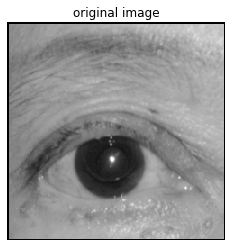

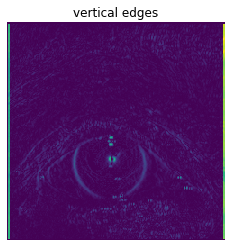

In [11]:
from scipy.signal import convolve

img = eyes[0][0]

plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('original image')
plt.show()

# Vertical edge filter
def vert_filter2d():
    return np.array([[1, 0, -1]])

vert_filter = vert_filter2d()
y_grad_image = np.absolute(convolve(img, vert_filter, mode='same'))
# y_grad_image = np.round(y_grad_image * 255 / (np.max(y_grad_image) - np.min(y_grad_image)))

plt.imshow(y_grad_image)
plt.axis('off')
plt.title('vertical edges')
plt.show()

In [12]:
y_grad_image.shape

(242, 242)

In [13]:
y_grad_image

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 140, 141, ...,   2, 199, 196],
       ...,
       [  0, 141, 136, ...,   0, 168, 167],
       [  0, 144, 140, ...,   1, 173, 168],
       [  0,   0,   0, ...,   0,   0,   0]])

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

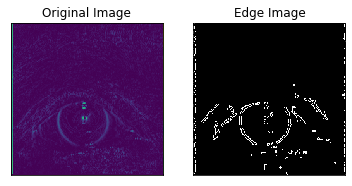

In [14]:
edges = cv2.Canny(y_grad_image.astype(np.uint8), 50, 150)
plt.subplot(121),plt.imshow(y_grad_image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [29]:
# Finding vertical edges
def verti_edges(img):
    img = cv2.GaussianBlur(img, (5, 5), 0)

#     # First, convolve to get vertical gradients
#     def vert_filter2d():
#         return np.array([[1, 0, -1]])
#     vert_filter = vert_filter2d()
#     y_grad_image = np.absolute(convolve(img, vert_filter, mode='same'))
#     y_grad_image = np.round(y_grad_image * 255 / (np.max(y_grad_image) - np.min(y_grad_image))) # Normalize the image
    
#     # Then, detect the edges.
#     edges = cv2.Canny(y_grad_image.astype(np.uint8), 50, 150, 3)
#     return edges


    # ------------ #
    
    # First, detect the edges.
    edges = cv2.Canny(img.astype(np.uint8), 50, 150, 3)
    
    # Then, convolve to get vertical gradients
    def vert_filter2d():
        return np.array([[1, 0, -1]])
    vert_filter = vert_filter2d()
    y_grad_image = np.absolute(convolve(edges, vert_filter, mode='same'))
    y_grad_image = np.round(y_grad_image * 255 / (np.max(y_grad_image) - np.min(y_grad_image))) # Normalize the image
    
    return y_grad_image
    
#     edges = np.round(edges * 255 / (np.max(edges) - np.min(edges)))
#     edges = cv2.threshold(edges.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)[1]
    

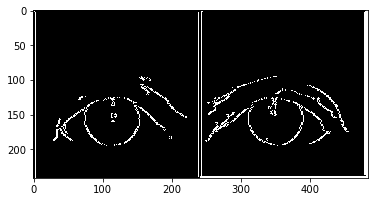

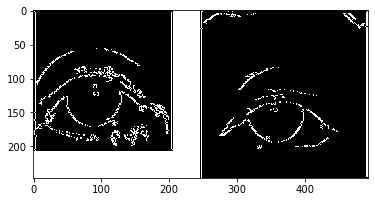

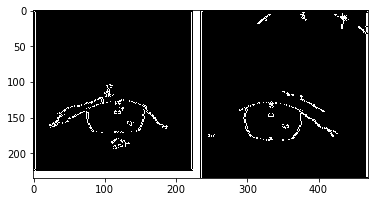

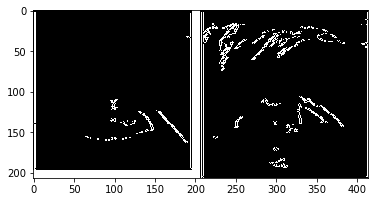

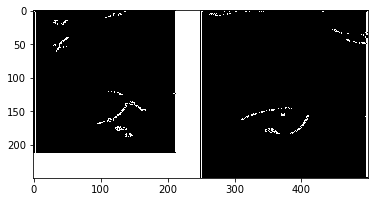

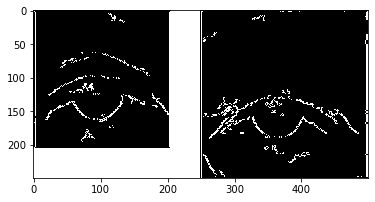

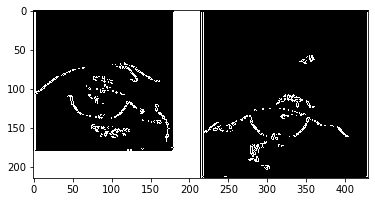

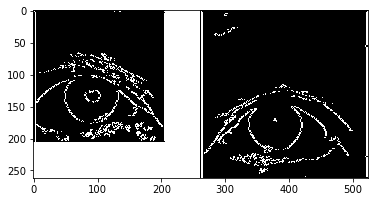

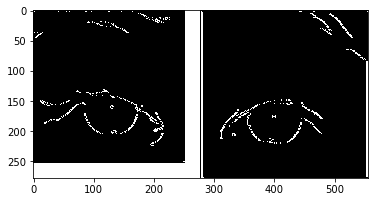

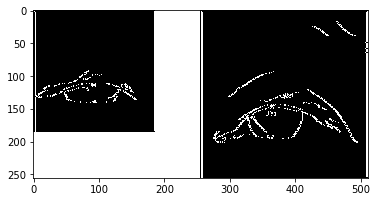

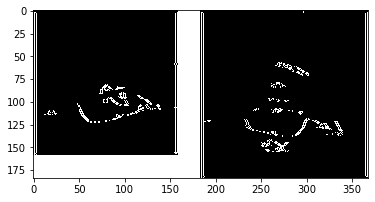

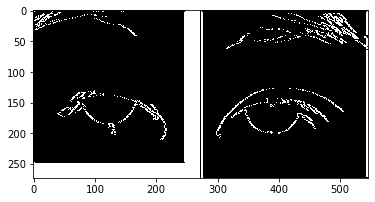

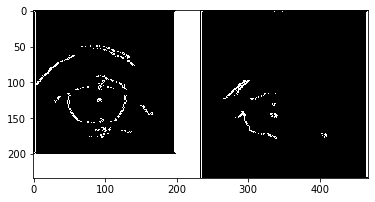

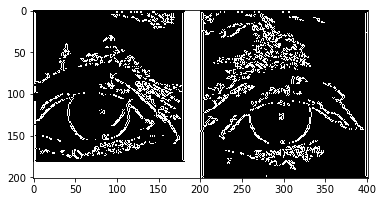

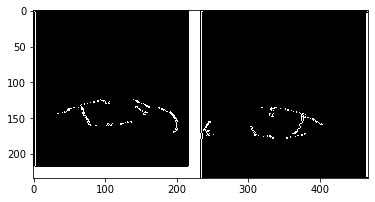

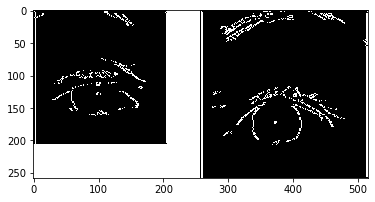

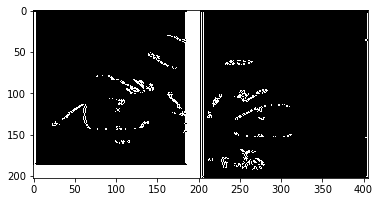

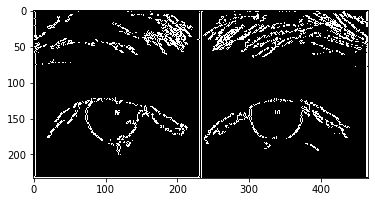

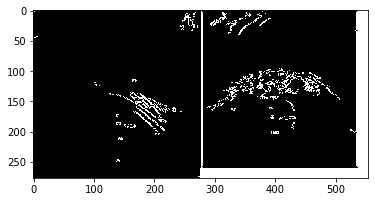

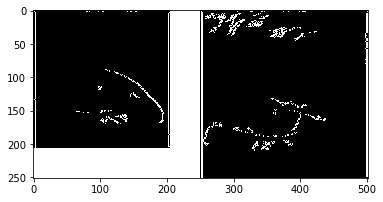

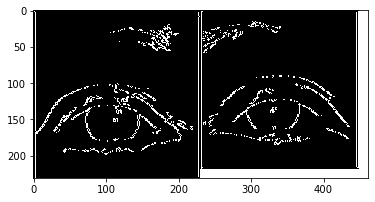

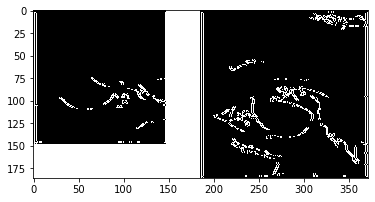

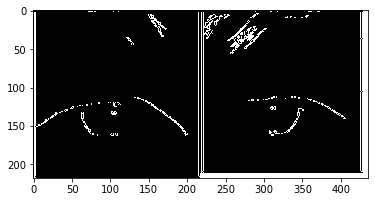

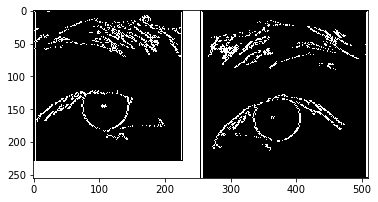

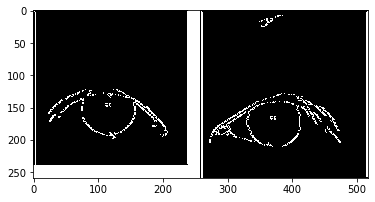

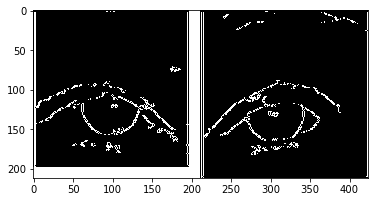

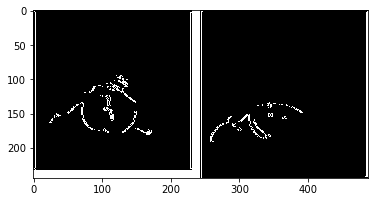

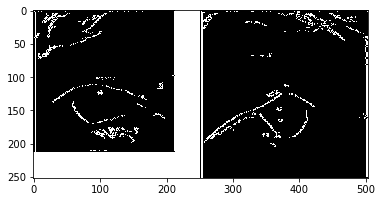

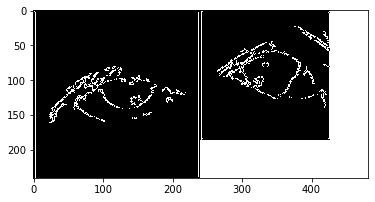

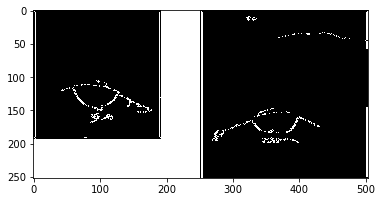

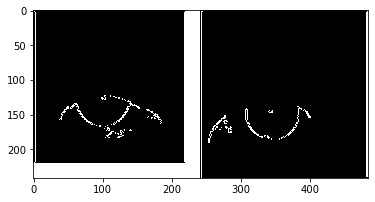

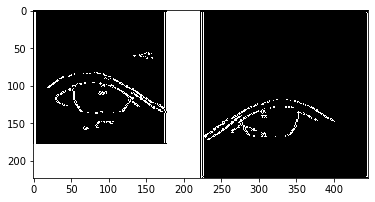

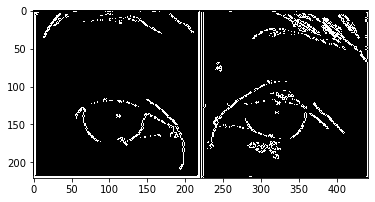

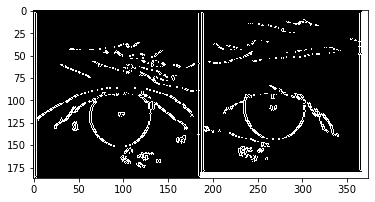

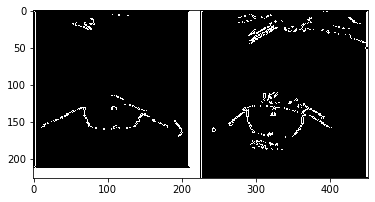

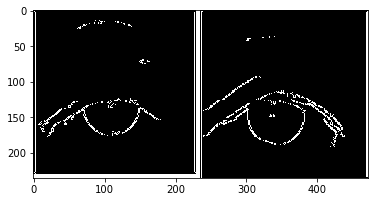

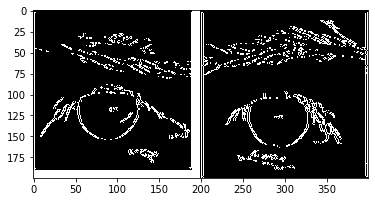

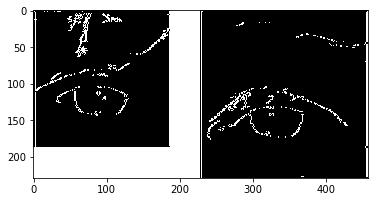

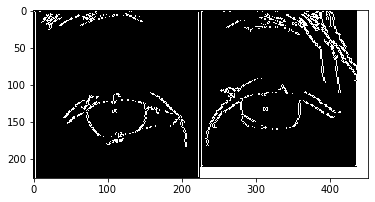

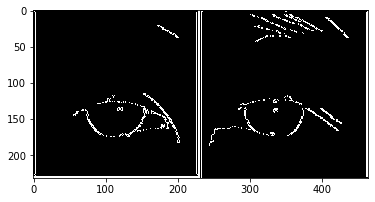

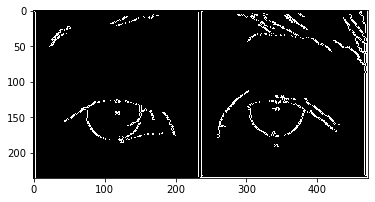

In [30]:
count = 0
for eye_pairs in eyes:
    
    show_two_eyes(verti_edges(eye_pairs[0]), verti_edges(eye_pairs[1]))

#     count += 1
#     if count > 10:
#         break

## Detect circles

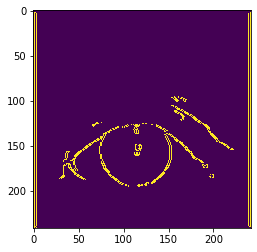

In [62]:
img = verti_edges(eyes[0][0]).astype(np.uint8)
cimg = img.copy()
plt.imshow(img)
plt.show()

In [63]:
circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 20, \
                            param1 = 200, param2 = 30, minRadius = 10)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)


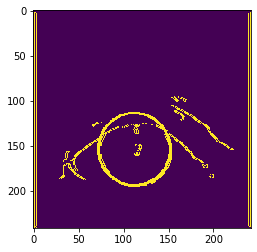

In [69]:
i = circles[0,:][0]
cv.circle(cimg,(i[0],i[1]),i[2],(255,0,0),2)
plt.imshow(cimg)
plt.show()

In [65]:
circles[0,:]

array([[112, 154,  40]], dtype=uint16)

# Circle detection

In [ ]:
def calc_circle_score(x, y, r, outline_img):
    height, width = outline_img.shape
    pi = math.pi
    n = 100
    points = [ (int(math.sin(2*pi / n*a)* r + y) , int(math.cos(2*pi / n*a) * r + x)) for a in range(0, n + 1) ]
    score = sum([outline_img[p] > 50 for p in points if p[0] < height and p[1] < width]) / n
    return score

# Define text info
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.3
fontColor = (255, 255, 255)
lineType = 1

def circle_detection(origin_dir, outline_dir, outfile_dir, filename):
    print('Processing file:', filename)
    
    # Loading files
    outline_img = cv2.imread(outline_dir + 'outline_cropped_' + filename)
    gray = cv2.cvtColor(outline_img, cv2.COLOR_BGR2GRAY)
    orig_height, orig_width = gray.shape
    
    origin_gray = cv2.imread(origin_dir + filename, 0)
    origin = cv2.imread(origin_dir + filename)
    origin_cropped = origin_gray[int(orig_height / 6): int(orig_height / 6 * 5), int(orig_width / 6): int(orig_width / 6 * 5)]
    
    # Find the lightest point
    origin_cropped = cv2.GaussianBlur(origin_cropped, (3, 3), 0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(origin_cropped)
    max_x = maxLoc[0]
    max_y = maxLoc[1]
    
    # Cropping
    gray = gray[int(orig_height / 6): int(orig_height / 6 * 5), int(orig_width / 6): int(orig_width / 6 * 5)]
    curr_height, curr_width = gray.shape
    gray_blurred = cv2.GaussianBlur(gray, (3, 3), 0) # For score calculation
    
    # Finding circles (tuning the parameters)
    best_x = -1
    best_y = -1
    best_r = -1
    results = []
    
    r_tmp = int(curr_width / 6)
    while True and r_tmp < int(curr_width / 3):
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 3, (curr_width + 1),
                      param1 = 30,
                      param2 = 15,
                      minRadius = r_tmp,
                      maxRadius = int(curr_width / 3))
        if circles is None:
            r_tmp += 1
            continue
        circles = np.uint16(np.around(circles))
        if len(circles[0,:]) == 0:
            break
        tmp_x = circles[0,:][0][0]
        tmp_y = circles[0,:][0][1]
        tmp_r = circles[0,:][0][2]
        results.append(
            (tmp_x, 
             tmp_y, 
             tmp_r, 
             (max_x - tmp_x) ** 2 + (max_y - tmp_y) ** 2,
             calc_circle_score(tmp_x, tmp_y, tmp_r, gray_blurred))
        )

        r_tmp += 1
    
    # Finding the best circle
    result_count = len(results) 
    results = sorted(results, key = lambda tup: tup[4], reverse = True) # Sort the circles by their score
    results = results[ : min([result_count, 10]) ]
    
    result_count = len(results) 
    results = sorted(results, key = lambda tup: tup[3], reverse = False) # Sort the circles by their distance to lightest point
    results = results[ : min([result_count, 5]) ]
    
    results = sorted(results, key = lambda tup: tup[2], reverse = True) # Sort the circles by their radius
    best_x = results[0][0]
    best_y = results[0][1]
    best_r = results[0][2]
    
    # Find the upper and lower eyelid
    y_upper = best_y
    tmp_y = best_y
    while tmp_y > best_y - best_r and tmp_y < curr_height:
        if gray_blurred[(tmp_y, best_x)] > 20:
            y_upper = tmp_y
        tmp_y -= 1
    
    y_lower = best_y
    tmp_y = best_y
    while tmp_y < best_y + best_r and tmp_y < curr_height:
        if gray_blurred[(tmp_y, best_x)] > 20:
            y_lower = tmp_y
        tmp_y += 1
        
    # Finalized, best circle
    x = best_x + int(orig_height / 6)
    y = best_y + int(orig_width / 6)
    y_upper = y_upper + int(orig_height / 6)
    y_lower = y_lower + int(orig_height / 6)
    
    # Draw the arrows to upper and lower eyelid
    cv2.arrowedLine(origin, (x, y), (x, y_upper), (0, 0, 255), 2)
    cv2.arrowedLine(origin, (x, y), (x, y_lower), (0, 0, 255), 2)
    
    # Drawing the best circle on the pic
    cv2.circle(origin, (x, y), best_r, (0, 255, 0), 2)
    cv2.circle(origin, (x, y), 2, (0, 255, 0), 5)
    
    upper_point = (x + best_r, y - best_r)
    lower_point = (x + best_r, y + best_r)
    
    upper_in_mm = 11.65 * (y - y_upper) / (best_r * 2)
    lower_in_mm = 11.65 * (y_lower - y) / (best_r * 2)
    
    cv2.putText(origin, str(upper_in_mm), upper_point, font, fontScale, fontColor, lineType)
    cv2.putText(origin, str(lower_in_mm), lower_point, font, fontScale, fontColor, lineType)

    cv2.imwrite('./Jacob/Stage2_output/detection/detected_' + filename , origin)